In [8]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
from dataclasses import asdict
from copy import copy

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.theory.resonance_statistics import make_res_par_avg
from ATARI.theory.xs import SLBW

import importlib

In [9]:
%matplotlib widget

### Generate a capture cross-section

The following code blocks use the ATARI/Syndat code to generate a synthetic or 'fake' set of resonance parameters for Ta-181. These resonance parameters correspond to a total, capture, and scattering cross-section that can be calculated with the imported SLBW function. The pointwise grid on which this cross-section is calculated is determined by the Experiment object. The exact set of resonance parameters can either be sampled randomly or explicitly defined.

In [26]:
ac=0.81271; M=180.948030; m=1; I=3.5; i=0.5; l_max=1     

E_min_max = [25, 100]
experiment_parameters = {'bw': {'val':0.1024,   'unc'   :   0},
                         'n':  {'val':0.067166,     'unc'   :0}}
exp = Experiment(E_min_max,  
                        experiment_parameters=experiment_parameters)

res_par_avg = make_res_par_avg(D_avg = 8.79, 
                            Gn_avg= 1.924, #0.658, 
                            n_dof = 1, 
                            Gg_avg = 64.0, 
                            g_dof = 10, 
                            print = False)

spin_groups = [ (3.0,1,0) ]
average_parameters = {'3.0':res_par_avg}
Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   

# resonance_ladder = Ta_pair.sample_resonance_ladder(energy_grid, spin_groups, average_parameters)

resonance_ladder = pd.DataFrame({"E":[31.8030900, 32.3453560, 43.3031830, 56.0645210, 63.9661590],
                                 "Gg":[54.9451300, 59.0939900, 59.7455500, 86.1347900, 67.1257900],
                                 "Gn":[0.3913400,0.0582700,2.9012500,2.1717400,0.0021400],
                                 "J":[3,3,3,3,3], "chs":[1,1,1,1,1], "lwave":[0,0,0,0,0], "J_ID":[1,1,1,1,1]})

print(resonance_ladder)

xs_tot, xs_scat, xs_cap = SLBW(exp.energy_domain, Ta_pair, resonance_ladder)
capture_df = pd.DataFrame({"E":exp.energy_domain, "theo_xs":xs_cap})
capture_df

           E        Gg       Gn  J  chs  lwave  J_ID
0  31.803090  54.94513  0.39134  3    1      0     1
1  32.345356  59.09399  0.05827  3    1      0     1
2  43.303183  59.74555  2.90125  3    1      0     1
3  56.064521  86.13479  2.17174  3    1      0     1
4  63.966159  67.12579  0.00214  3    1      0     1


,E,theo_xs
0,100.000000,0.000636
1,99.919540,0.000639
2,99.839176,0.000641
3,99.758910,0.000644
4,99.678740,0.000646
...,...,...
2480,25.042254,0.011493
2481,25.032168,0.011473
2482,25.022088,0.011454
2483,25.012014,0.011434


In [39]:
capture_df.theo_xs[np.isclose(capture_df.E, 31.803090)]
np.searchsorted(capture_df.E.values, 31.803090)

0

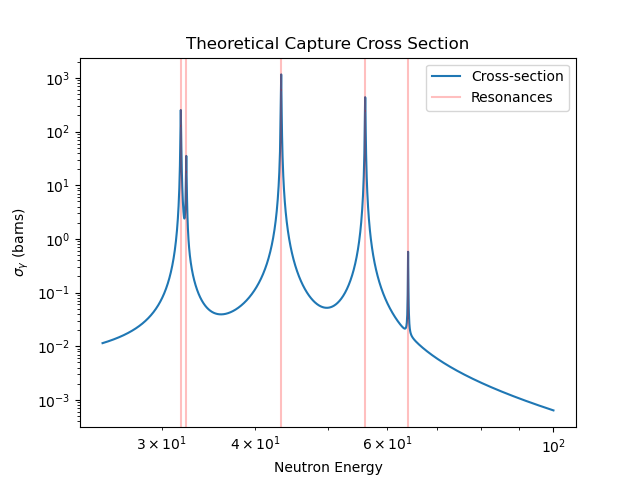

In [68]:

figure()
plot(capture_df.E, capture_df.theo_xs)
yscale('log')
xscale('log')
xlabel('Neutron Energy')
ylabel(r'$\sigma_{\gamma}$ (barns)')
title("Theoretical Capture Cross Section")


for i, row in resonance_ladder.iterrows():
    axvline(row.E, color='r', alpha=0.25) #, label=f"Res: {i}")
    _, _, max =  SLBW([row.E], Ta_pair, resonance_ladder)
    hlines(max.item()/2, xmin=row.E-(row.Gg+row.Gn)*1e-3, xmax=row.E+(row.Gg+row.Gn)*1e-3, alpha=0.25, color='r')

legend(["Cross-section", "Resonances"])

# The Goal

In reality, we don't know what the *exact* resonance parameters (and therefore pointwise reaction cross-sections) are for Ta-181. Rather, we estimate them based on experimental measurement data. The overarching goal of the ATARI research group (Noah, Jake, & Oleksii) is to improve the method used to infer resonance parameters given measurement data. In order to aid in this development, we are using synthetically generated measurement data.

This allows us to know the true/exact parameters for a set of measurement data. Then, we can give feedback to our inference method(s) based on the known solutions. However, we want the synthetic data to be very realistic such that what we "learn" from it can be extrapolated to real measurement data. We have developed a methodology for how to do this and applied it to total cross-section data. We published a paper on this, the preprint can be found [here](https://arxiv.org/abs/2303.09698). Now, we want to apply a similar methodology to be able to *generate* realistic measurement data for capture cross-section experiments. In statistical/machine-learning lingo, we want to develop a *generative* model. A good resource for this method can be found [here](https://betanalpha.github.io/assets/case_studies/generative_modeling.html).

Ultimately we are sampling noise around the theoretical cross-section based on some probability density function (PDF). The most simple example of this would be to use a normal distribution (shown below) - though this would not be very realistic.

In [82]:
def get_data(theo_xs):
    unc_scale = 0.05
    data = abs(np.random.default_rng().normal(theo_xs, np.sqrt(theo_xs)*unc_scale ))
    data_unc = np.sqrt(data)*unc_scale
    return data, data_unc

data, data_unc = get_data(capture_df.theo_xs)
capture_df["exp"] = data
capture_df["exp_unc"] = data_unc


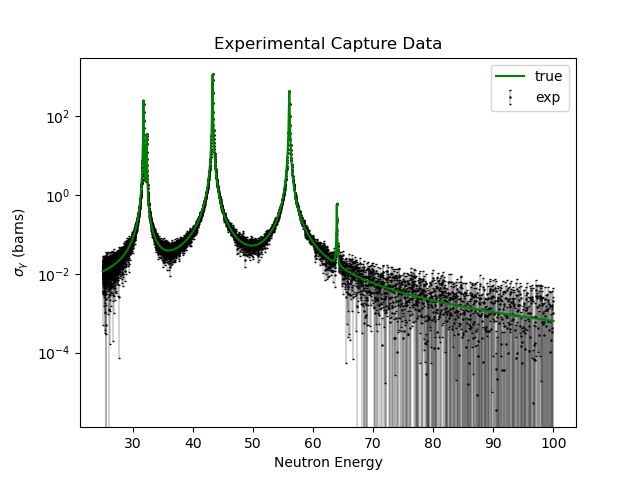

In [83]:

figure()
plot(capture_df.E, capture_df.theo_xs, ms=1, color='g', label='true')
errorbar(capture_df.E,capture_df.exp, yerr=capture_df.exp_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=0.25, markersize=1.5, capsize=1, label='exp')

# ylim([-.1, 1])
yscale('log')
xlabel('Neutron Energy')
ylabel(r'$\sigma_{\gamma}$ (barns)')
title("Experimental Capture Data")
legend()

### Some Guidance

Unfortunately, the PDF for measurement data is not as simple as a normal distribution. The measurement data we want to replicate is a mathematical combination of several uncertain variables ($y_1, y_2, ... y_n$). Assuming just two uncertain variables for simplicity, the generative model we are after can be given as $\pi(y_1, y_2)$.

$\pi(y_1, y_2)$ is not known or simple. Instead, we take an approach called *ancestral* sampling. We know about the *process* by which a cross-section is measured, and we have a good idea of the PDFs for $y_1$ and $y_2$ independently. 

Therefore, we can construct a generative model like a narative or story like this:

$\pi(y_2|y_1)\pi(y_1)$

Where we can independently sample $y_2$ from $\pi(y_2|y_1)$ once we have a fixed value for $y_1$. That fixed value is sampled independently from $\pi(y_1)$.
